In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision.models import vgg16, VGG16_Weights
from torchvision import transforms
import torch.optim as optim
from PIL import Image, ImageEnhance
import cv2
import json
import os
import random
import time

In [2]:
start_time = time.perf_counter()

In [3]:
def hist_eq(img_out) :
    img_out[:, :, 0] = cv2.equalizeHist(img_out[:, :, 0])
    img_out[:, :, 1] = cv2.equalizeHist(img_out[:, :, 1])
    img_out[:, :, 2] = cv2.equalizeHist(img_out[:, :, 2])
    return img_out

In [4]:
class CenterCrop224(object):
    
    def __init__(self, output_size=224):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def __call__(self, image):
        img = np.array(image)
        h, w = img.shape[:2]
        sz = self.output_size
        
        if h == w: 
            return cv2.resize(img, (sz, sz), cv2.INTER_AREA)
        
        elif h > w:
            scaling_factor = sz / w
            x_shape = sz
            y_shape = int(h * scaling_factor)
            img_reshaped = cv2.resize(img, (x_shape, y_shape), cv2.INTER_AREA)
            offset = int((y_shape - sz) / 2)
            img_reshaped = img_reshaped[offset:offset + sz, :, :]
            
        else :
            scaling_factor = sz / h
            x_shape = int(w * scaling_factor) 
            y_shape = sz
            img_reshaped = cv2.resize(img, (x_shape, y_shape), cv2.INTER_AREA)
            offset = int((x_shape - sz) / 2)
            img_reshaped = img_reshaped[:, offset:offset+sz, :]
        return img_reshaped
cc224 = CenterCrop224()

In [5]:
transform = transforms.Compose([CenterCrop224(), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                     std=[0.229, 0.224, 0.225])])

# transform = transforms.Compose([VGG16_Weights.IMAGENET1K_V1.transforms])
# transform = VGG16_Weights.IMAGENET1K_V1.transforms

In [6]:
img = cv2.cvtColor(cv2.imread('../images/data/puffer.JPEG'), cv2.COLOR_BGR2RGB)
image = transforms.ToPILImage()(img).convert("RGB")
img = transform(img)
# img = Image.open('puffer.JPEG')
# print(img.size)

# img = img.transform([244], transforms.InterpolationMode.BILINEAR)

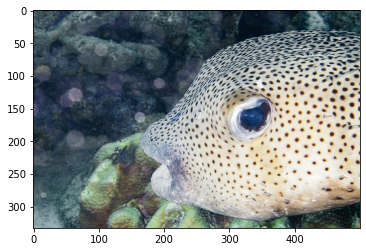

In [7]:
plt.imshow(image)

In [8]:
f_labels = open('../imagenet_class_index.json', 'r')
labels = json.load(f_labels)
f_labels.close()

In [9]:
class ConvVgg16(nn.Module):
    def __init__(self, save_switches=False):
        super().__init__()
        
        self.save_switches = save_switches
        # indices of Conv2d layres
        self.modules_no = []
        
        # self.features = vgg16(pretrained=True).features
        self.features = vgg16(weights='DEFAULT').features
        
        for i, feature in enumerate(self.features) :
            if isinstance(feature, nn.MaxPool2d):
                self.features[i] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices = True)
            
            elif isinstance(feature, nn.Conv2d):
                self.modules_no.append(i)
            
        # self.avgpool = vgg16(pretrained=True).avgpool
        self.avgpool = vgg16(weights='DEFAULT').avgpool
        
        # self.classifier = vgg16(pretrained=True).classifier
        self.classifier = vgg16(weights='DEFAULT').classifier
                        
        
    def forward (self, x) :
        conv_results = {}
        maxpool_indices = {}
        for i, layer in enumerate(self.features):
            
            if isinstance(layer, nn.MaxPool2d):
                x, index = layer(x)
                maxpool_indices[i] = index
                
            else :
                x = layer(x)
            
            if isinstance(layer, nn.Conv2d):
                conv_results[i] = x
            
        
            
        x = self.avgpool(x)
        x = x.flatten()
        x = self.classifier(x)
        
        
        if not self.save_switches :
            return x    
            
        return x, conv_results, maxpool_indices
    

In [10]:
class ConvDeconvVGG16(nn.Module) :
    def __init__(self) :
        
        super().__init__()
        
        
        self.conv_model = ConvVgg16(save_switches=True)

        
        self.conv_indices = []
        self.maxpool_indices = []
        
        module_list = []
        
        for i, layer in enumerate(self.conv_model.features) :
            if isinstance(layer, nn.Conv2d):
                module_list.append(nn.ConvTranspose2d(layer.out_channels, layer.in_channels, layer.kernel_size, stride=layer.stride, padding=layer.padding))
                module_list[i].weight.data = layer.weight.data
                self.conv_indices.append(i)
                
            elif isinstance(layer, nn.MaxPool2d):
                module_list.append(nn.MaxUnpool2d(kernel_size=2, stride=2))
                self.maxpool_indices.append(i)
                
            elif isinstance(layer, nn.ReLU):
                module_list.append(nn.ReLU(inplace=True))
        
        module_list.reverse()
        self.module_list = nn.ModuleList(module_list)
     
    
    def __zero_activation(self, y, k) :
        if k == 'channel' :
            y_sum = y.sum(axis=1).sum(axis=1)
            y_argmax = y_sum.argmax().item()
            y_zerod = torch.zeros_like(y)
            y_zerod[y_argmax, :, :] = y[y_argmax, :, :]
            return y_zerod
        
        elif k == 'pixel' :
            y_idx = y.argmax().item()
            y_max = y.max().item()
            y_zerod = torch.zeros_like(y).flatten()
            y_zerod[y_idx] = y_max
            return y_zerod.reshape(y.shape)
    
        
    def forward(self, x, layer_ix, zero_type='channel') :
        
        conv_pred_vector, conv_results, switches  = self.conv_model(x)
        conv_pred = conv_pred_vector.argmax().item()
        
        y = conv_results[self.conv_indices[layer_ix]]
        y = self.__zero_activation(y, zero_type)

        
        
        for i, layer in enumerate(self.module_list[(30 - self.conv_indices[layer_ix]):]) :
            if isinstance(layer, nn.MaxUnpool2d):
                y = layer(y, switches[self.conv_indices[layer_ix] - i])
            else :
                y = layer(y)
                
        ret = {"pred_prob" : conv_pred_vector, "pred" : conv_pred, "conv_results": conv_results, "deconv" : y}
        return ret
        
        

In [11]:
model = ConvDeconvVGG16()

In [12]:
out = model(img, 7)
print(f"Class : {out['pred']}: {labels[str(out['pred'])][1]}")

Class : 397: puffer


## Image Loading and Scaling Functions

In [13]:
def load_image(path="../images/data/tench.JPEG"):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    return img

### Conv Network

### Deconv

In [14]:
def reconstruction(img, zero_type='channel'):

    reconstructed_img = np.zeros((6, 224, 224, 3), dtype=np.int32)

    for i, layer_i in enumerate(model.conv_indices):

        if i > 5:
            break
        
        out = model(img, layer_i, zero_type)

        # for j in range(9):

        img_out = out['deconv'].permute(1, 2, 0).detach().cpu().numpy()
        img_out = (img_out - img_out.min()) / (img_out.max() - img_out.min())
        img_out = (img_out * 255).astype(np.uint8)


        # Histogram equalization on img_out
        img_out[:, :, 0] = cv2.equalizeHist(img_out[:, :, 0])
        img_out[:, :, 1] = cv2.equalizeHist(img_out[:, :, 1])
        img_out[:, :, 2] = cv2.equalizeHist(img_out[:, :, 2])

        reconstructed_img[i] = img_out

    return reconstructed_img

In [15]:
def reconstruction_plots(img, name, zero_type='channel'):

    # Original Image
    # plt.imshow(img)
    # plt.title("Input Image")
    # plt.axis("off")
    # plt.show()

    reconstructed_img = reconstruction(transform(img), zero_type)

    fig, axes = plt.subplots(3, 3, figsize=(14, 12))        
    fig.set_facecolor("white")
    for i in range(6):
        # plot_layer_i(reconstructed_img, i)

        axes[i // 3][i % 3].imshow(reconstructed_img[i])
        axes[i // 3][i % 3].set_xticklabels([])
        axes[i // 3][i % 3].set_yticklabels([])
        axes[i // 3][i % 3].set_title(f"Layer {i + 1}")

    axes[2][1].imshow(img)
    axes[2][1].set_xticklabels([])
    axes[2][1].set_yticklabels([])
    axes[2][1].set_title("Input Image")
    
    axes[2][0].axis("off")
    axes[2][2].axis("off")

    # plt.subplots_adjust(wspace=0, hspace=0)
    # plt.show()
    # fig.savefig(name)

    plt.show()

### Visualizations

The Topmost Activation is kept and the rest are zeroed out (as mentioned in the paper).

Zeroing activation has been implemented channel-wise and pixel-wise.

The outputs shown are first channel-wise then pixel-wise.

In [16]:
image_dir = "../images/imagenet-sample-images/"

files = random.sample(os.listdir(image_dir), k=3)

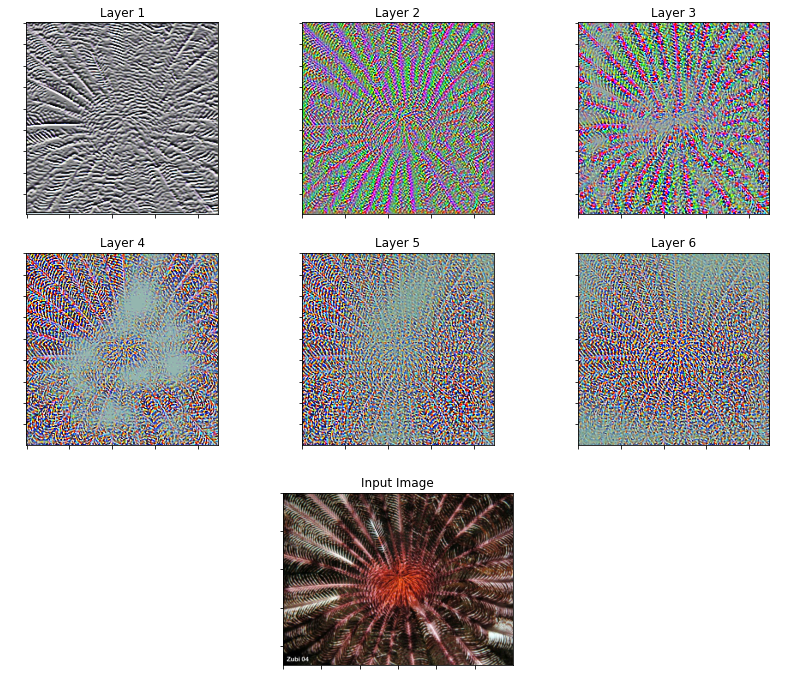

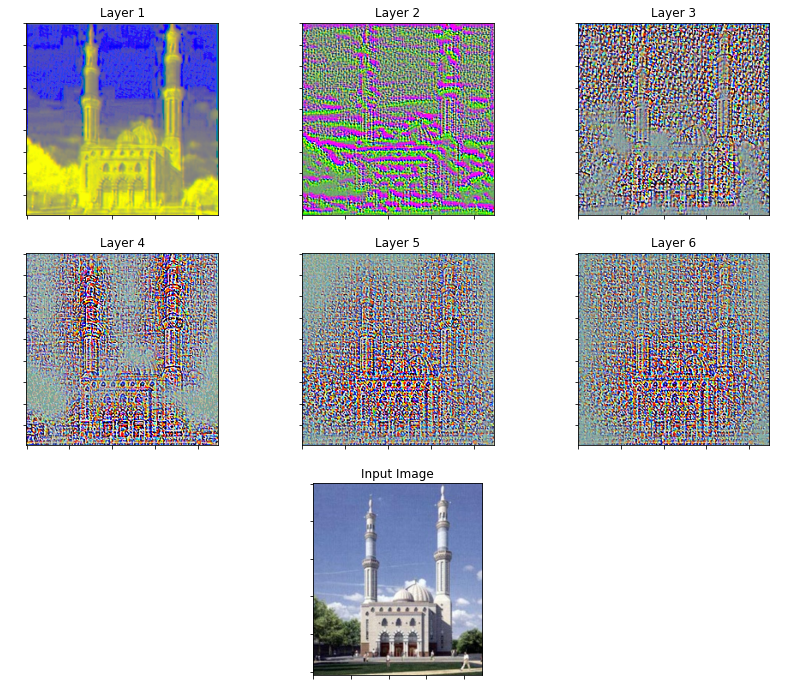

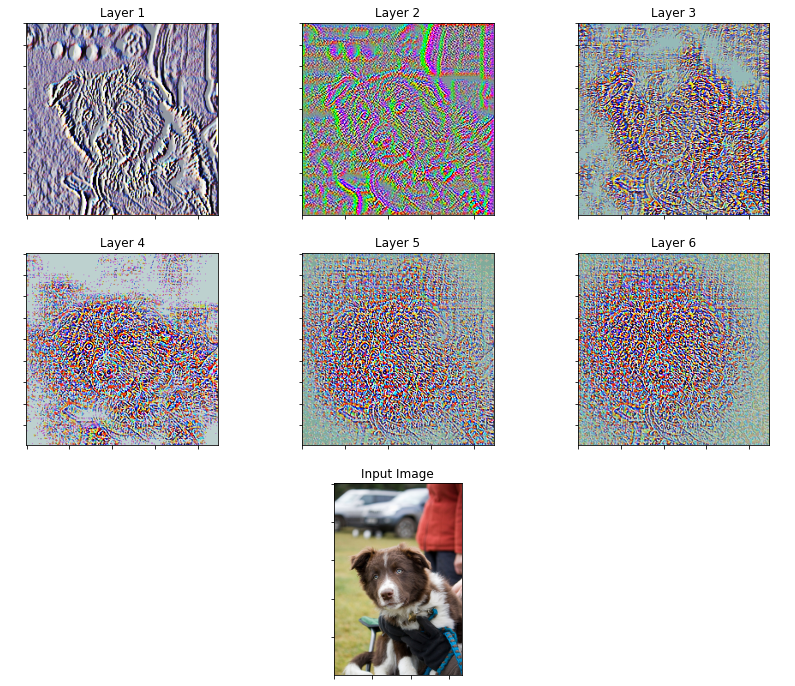

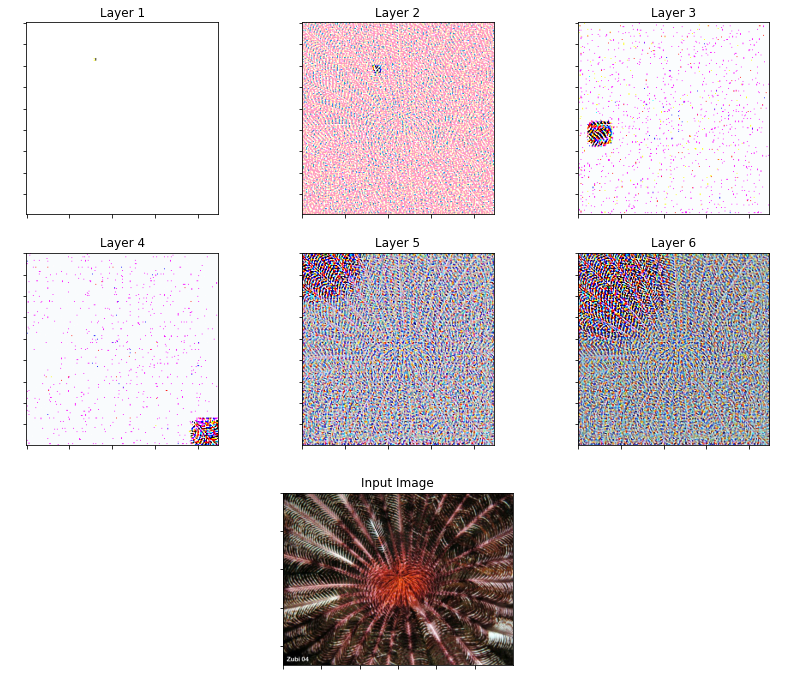

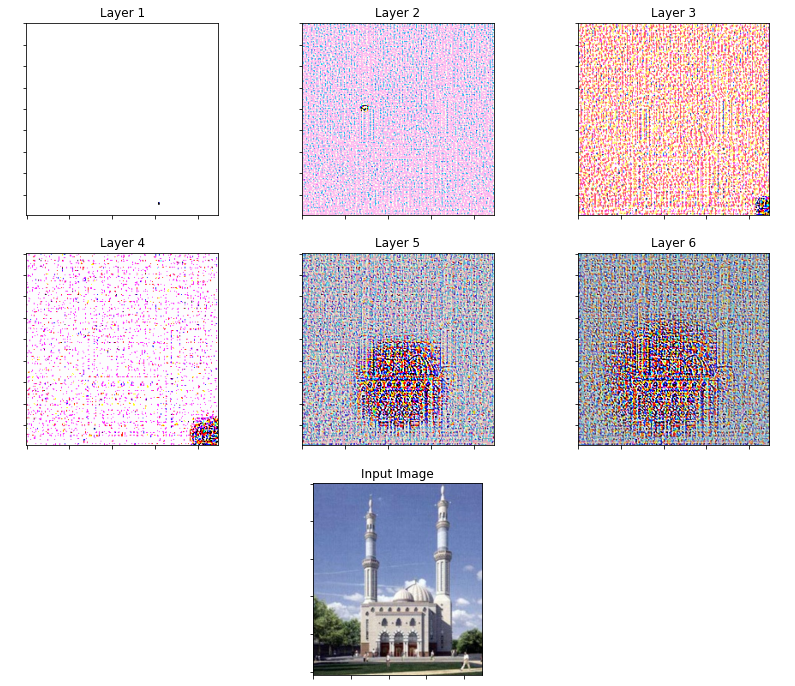

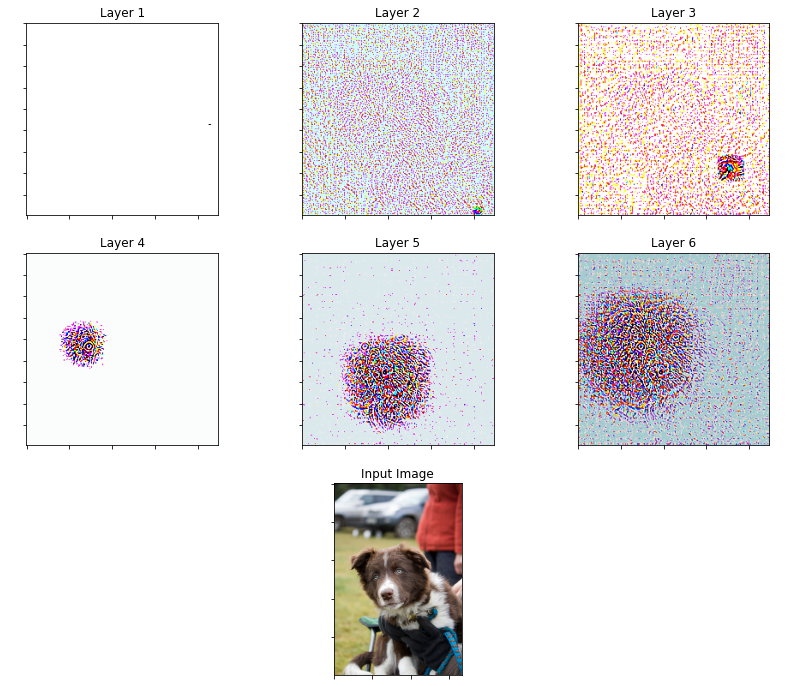

In [17]:
for zero_type in ['channel', 'pixel']:
    for file in files:
        reconstruction_plots(load_image(os.path.join(image_dir, file)), f"../images/visualized/{zero_type}_{file}", zero_type)

### Feature Invariance

In [18]:
def resize_image(img, size):
    h, w = img.shape[:2]

    if h == w: 
        return cv2.resize(img, (size, size), cv2.INTER_AREA)

    elif h > w:
        scaling_factor = size / w
        x_shape = size
        y_shape = int(h * scaling_factor)
        img_reshaped = cv2.resize(img, (x_shape, y_shape), cv2.INTER_AREA)
        offset = int((y_shape - size) / 2)
        img_reshaped = img_reshaped[offset:offset+size, :, :]
        
    else :
        scaling_factor = size / h
        x_shape = int(w * scaling_factor) 
        y_shape = size
        img_reshaped = cv2.resize(img, (x_shape, y_shape), cv2.INTER_AREA)
        offset = int((x_shape - size) / 2)
        img_reshaped = img_reshaped[:, offset:offset+size, :]
        
    return img_reshaped

def scale_image(img, scale_ratio):
    """
    scale_ratio: must be >= 1
    
    Scale and then crop the center of the image to the original size
    """
    
    h, w = img.shape[:2]
    img_scaled = cv2.resize(img, (int(w * scale_ratio), int(h * scale_ratio)))

    return img_scaled[int((h * scale_ratio - h) / 2):int((h * scale_ratio + h) / 2), 
                          int((w * scale_ratio - w) / 2):int((w * scale_ratio + w) / 2), :]
    

def vert_trans_image(img, y):
    rows, cols = img.shape[:2]
    translation_matrix = np.float32([[1, 0, 0], [0, 1, y]])
    img_translated = cv2.warpAffine(img, translation_matrix, (cols, rows))
    return img_translated

def rotate_image(img, angle):
    """
    angle: rotation angle (in degrees)
    """
    rows, cols = img.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D(( (cols - 1)/2 , (rows - 1)/2), angle, 1)
    img_rotated = cv2.warpAffine(img, rotation_matrix, (cols, rows))
    return img_rotated

def open_image(path):
    img = cv2.imread(path)
    return img

In [19]:
def euclidean_distance(vec1, vec2):
    # dim=None flattens the vector to find the euclidean distance
    return torch.linalg.vector_norm(vec1 - vec2, ord=2, dim=None)

In [20]:
model = ConvDeconvVGG16()

In [21]:
json_data = json.load(open('../Training/imagenet_class_index.json', 'r'))

In [22]:
image_dir = "../images/imagenet-sample-images/"

def get_random_images(x=3):
    """Gets x images from the test set"""
    image_classes = np.random.choice(1000, x)
    image_class_names = [ json_data[str(i)][1] for i in image_classes]
    image_names = [ json_data[str(i)][0] + "_" + json_data[str(i)][1] + ".JPEG" for i in image_classes]
    image_files = [os.path.join(image_dir, image_name) for image_name in image_names]
    images = [open_image(image_file) for image_file in image_files]
    
    return image_classes, image_class_names, images

In [23]:
def plot_sample_images(func, func_title, y):
    _, _, img = get_random_images()
    img = resize_image(img[0], 224)

    fig, ax = plt.subplots(1, y.size, figsize=(20, 5.5))
    fig.set_facecolor('white')
    
    for i, val in enumerate(y):
        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])
        translated_img = func(img, val)
        ax[i].imshow(translated_img)
        ax[i].set_title("%s: %.2f" % (func_title, val))
        ax[i].axis('off')

    fig.suptitle(f"Sample {func_title}")
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

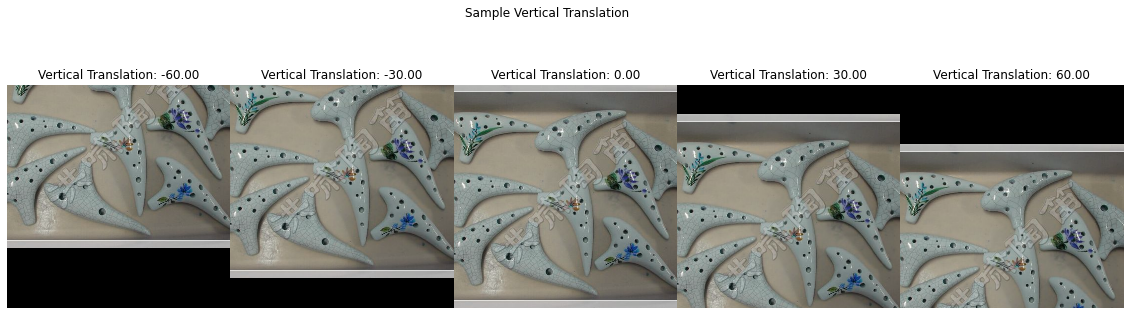

In [24]:
plot_sample_images(vert_trans_image, "Vertical Translation", np.arange(-60, 61, 30))

In [49]:
def plot_all(image_names, probabilities, distances_1, distances_6, func_title, y):
    
    fig, ax = plt.subplots(1, 3, figsize=(16, 4.5))
    
    fig.set_facecolor("white")
    
    for i, val in enumerate(image_names):
        
        ax[0].plot(y, probabilities[i], label=val)
        ax[1].plot(y, distances_1[i], label=val)
        ax[2].plot(y, distances_6[i], label=val)
        
    ax[0].set_ylabel("True Probability")
    ax[1].set_ylabel("Canonical Distance")
    ax[2].set_ylabel("Canonical Distance")
    
    ax[0].set_xlabel(func_title)
    ax[1].set_xlabel(func_title)
    ax[2].set_xlabel(func_title)

    ax[0].set_title(f"Prediction Probabilities")
    ax[1].set_title(f"{func_title}: Layer 1")
    ax[2].set_title(f"{func_title}: Layer 12")
    
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    
    fig.suptitle(func_title)
    
    plt.show()

In [50]:
def compute_probability(img, y, func, image_class):
    
    probabilities = np.zeros(y.shape)

    for i, val in enumerate(y):
        changed_img = func(img, val)
        probabilities[i] = model(transform(changed_img), 7)['pred_prob'][image_class]
    return probabilities

In [51]:

def plot_func(func, func_title, y):
    image_classes, image_names, images = get_random_images()

    probabilities = np.zeros((len(images), y.size))
    distances_1 = np.zeros((len(images), y.size))
    distances_12 = np.zeros((len(images), y.size))
    
    
    for i, img in enumerate(images):
                
        output_dict = model(transform(img), 7)["conv_results"]
        untransformed_feature_vector_1 = output_dict[model.conv_indices[0]]
        untransformed_feature_vector_12 = output_dict[model.conv_indices[12]]
        
        for j, v in enumerate(y):
            changed_img = func(img, v)
            output_dict_j = model(transform(changed_img), 7)
            
            distances_1[i][j] = euclidean_distance(untransformed_feature_vector_1, output_dict_j["conv_results"][model.conv_indices[0]])
            distances_12[i][j] = euclidean_distance(untransformed_feature_vector_12, output_dict_j["conv_results"][model.conv_indices[12]])
            
            probabilities[i][j] = output_dict_j["pred_prob"][image_classes[i]]

    return probabilities, distances_1, distances_12, image_names

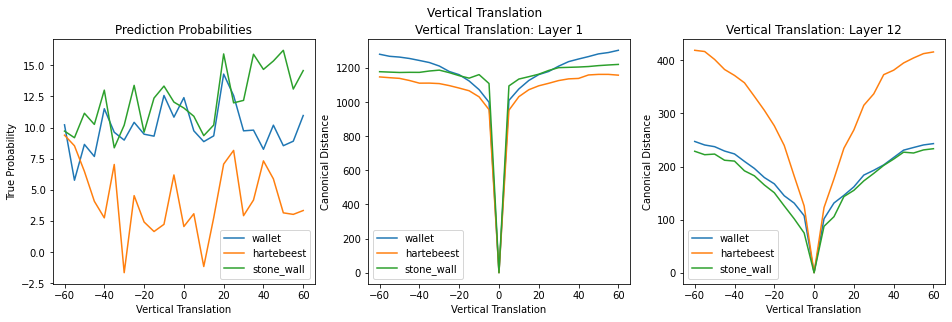

In [52]:
y = np.arange(-60, 61, 5)
p ,d1, d6, image_names = plot_func(vert_trans_image, "Vertical Translation", y)
plot_all(image_names, p, d1, d6, "Vertical Translation", y)

#### Scaling

In [53]:
y = np.arange(1, 2.01, 0.05)
p ,d1, d6, image_names = plot_func(scale_image, "Scaling (in ratio)", y)

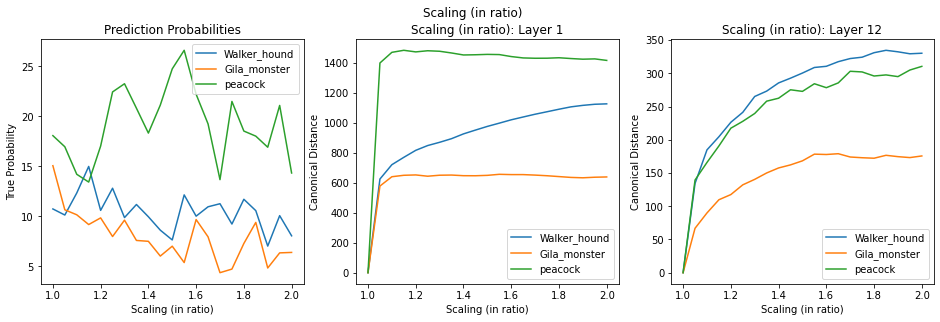

In [54]:
plot_all(image_names, p, d1, d6, "Scaling (in ratio)", y)

#### Rotation

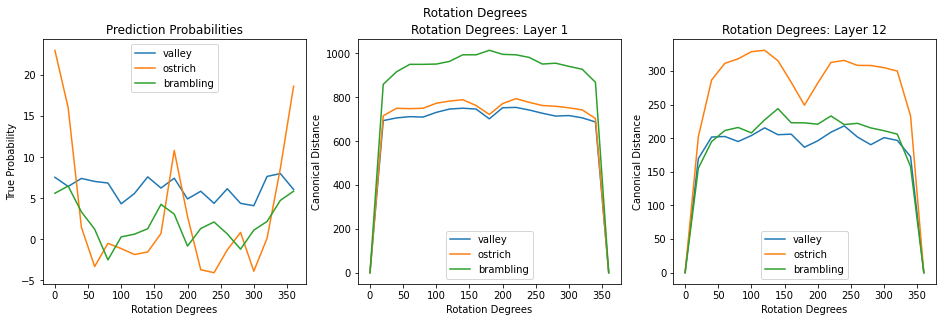

In [55]:
y = np.arange(0, 361, 20)
p ,d1, d6, image_names = plot_func(rotate_image, "Rotation Degrees", y)
plot_all(image_names, p, d1, d6, "Rotation Degrees", y)

### Occlusion

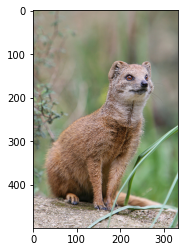

In [32]:
model = ConvDeconvVGG16()

img = cv2.cvtColor(cv2.imread('../images/data/mong.JPEG'), cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [33]:
def generate_class_map(img, label, occ_sz, step) :
    
    dim = ((224 - occ_sz) // (step - 1)) + 1
    
    class_map = np.zeros(shape=(dim, dim))
    prob_map = np.zeros(shape=(dim , dim))
    
    for i in range(0, 244 - occ_sz, step) :
        for j in range(0, 244 - occ_sz, step) :
            
            img_cpy = transform(img.copy())
            img_cpy[:, i:i+occ_sz, j:j+occ_sz] = 0.5
            
            res = model(img_cpy, 1, zero_type='pixel')
            
            pred = res['pred']
            oc_label = res['pred_prob'][label].item()
            
            class_map[i // step, j // step] = pred
            prob_map[i // step, j // step] = oc_label
    
    return class_map, prob_map

In [34]:
class_map, prob_map = generate_class_map(img, 298, 55, 10)

In [35]:
img = cv2.cvtColor(cv2.imread('../images/data/mong.JPEG'), cv2.COLOR_BGR2RGB)
occ_sz = 50
img_cpy = transform(img)
res = model(img_cpy, 9, zero_type='pixel')
img_out_og = res['deconv'].permute(1, 2, 0).detach().cpu().numpy()
img_out_og = (img_out_og - img_out_og.min()) / (img_out_og.max() - img_out_og.min())
img_out_og = (img_out_og * 255).astype(np.uint8)

In [36]:
img_cpy = transform(img.copy())
img_cpy[:, 20:20 + occ_sz, 130:130 + occ_sz] = 0.5
res = model(img_cpy, 9, zero_type='pixel')
img_out_occ = res['deconv'].permute(1, 2, 0).detach().cpu().numpy()
img_out_occ = (img_out_occ - img_out_occ.min()) / (img_out_occ.max() - img_out_occ.min())
img_out_occ = (img_out_occ * 255).astype(np.uint8)


Text(0.5, 1.0, 'Class Map')

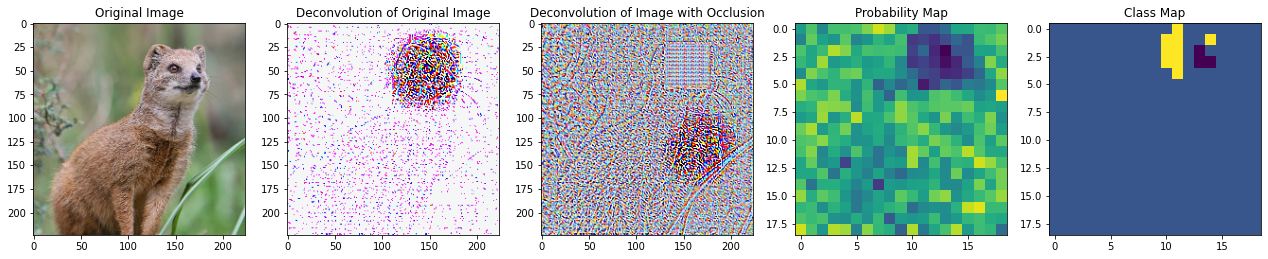

In [37]:
fig, ax = plt.subplots(1, 5, figsize=(22, 18))
fig.set_facecolor('white')

ax[0].imshow(cc224(img))
ax[0].set_title('Original Image')

ax[1].imshow(hist_eq(img_out_og))
ax[1].set_title('Deconvolution of Original Image')

ax[2].imshow(hist_eq(img_out_occ))
ax[2].set_title('Deconvolution of Image with Occlusion')

ax[3].imshow(prob_map)
ax[3].set_title('Probability Map')

ax[4].imshow(class_map)
ax[4].set_title('Class Map')

In [38]:
end_time = time.perf_counter()
ms = (end_time-start_time)
print(f"Elapsed {ms:.03f} sec.")

Elapsed 208.543 sec.
